# Day 83: Introduction to Transformers and Attention Mechanisms

## Introduction

Welcome to one of the most revolutionary topics in modern machine learning: **Transformer architectures**. Since their introduction in the landmark 2017 paper "Attention Is All You Need" by Vaswani et al., transformers have fundamentally changed how we approach sequence modeling tasks, particularly in Natural Language Processing (NLP).

### Why Transformers Matter

Before transformers, sequence-to-sequence tasks relied heavily on Recurrent Neural Networks (RNNs) and Long Short-Term Memory networks (LSTMs). While effective, these architectures had significant limitations:

1. **Sequential Processing**: RNNs process sequences one element at a time, making parallelization difficult
2. **Vanishing Gradients**: Long sequences lead to vanishing gradient problems
3. **Limited Context**: Difficulty in capturing long-range dependencies

Transformers solve these problems through a mechanism called **attention**, which allows the model to weigh the importance of different parts of the input sequence simultaneously.

### Learning Objectives

By the end of this lesson, you will understand:

- The theoretical foundations of attention mechanisms
- How self-attention works mathematically
- The complete transformer architecture
- Positional encodings and why they're necessary
- Multi-head attention and its benefits
- How to implement attention mechanisms from scratch using NumPy
- Practical applications of transformers in NLP and beyond

### Real-World Impact

Transformers power many systems you use daily:
- ChatGPT, Claude, and other large language models
- Google Translate and other machine translation services
- Document summarization tools
- Code completion in IDEs
- Image generation models like DALL-E and Stable Diffusion

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyBboxPatch
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
NumPy version: 2.3.4


## Theoretical Foundation

### The Attention Mechanism

The core innovation of transformers is the **attention mechanism**, which allows the model to focus on different parts of the input sequence when processing each element.

#### Self-Attention Formula

The fundamental equation for self-attention is:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Where:
- $Q$ (Query): "What am I looking for?" - matrix of shape $(n, d_k)$
- $K$ (Key): "What do I have?" - matrix of shape $(m, d_k)$
- $V$ (Value): "What is the actual content?" - matrix of shape $(m, d_v)$
- $d_k$: Dimension of the key vectors (used for scaling)
- $n$: Number of queries
- $m$: Number of key-value pairs

#### Why This Works

1. **Similarity Scoring**: $QK^T$ computes similarity between queries and keys
2. **Scaling**: Division by $\sqrt{d_k}$ prevents softmax saturation
3. **Normalization**: Softmax converts scores to a probability distribution
4. **Weighted Sum**: Multiply by $V$ to get the weighted combination of values

### Scaled Dot-Product Attention

The attention scores before softmax are:

$$\text{Score}(q_i, k_j) = \frac{q_i \cdot k_j}{\sqrt{d_k}}$$

The scaling factor $\sqrt{d_k}$ is crucial because:
- Dot products grow with dimensionality
- Large values lead to small gradients in softmax
- Scaling stabilizes training

### Multi-Head Attention

Instead of a single attention function, transformers use **multi-head attention**:

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

Where each head is:

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$

Benefits:
- Captures different types of relationships
- Attends to information from different representation subspaces
- Similar to having multiple convolutional filters in CNNs

### Positional Encoding

Transformers have no inherent notion of sequence order, so we add positional information:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

Where:
- $pos$: Position in sequence (0, 1, 2, ...)
- $i$: Dimension index (0, 1, ..., $d_{model}/2 - 1$)
- $d_{model}$: Model dimension

This sinusoidal function allows the model to:
- Learn relative positions easily
- Extrapolate to longer sequences than seen during training
- Represent positions uniquely

In [2]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Compute scaled dot-product attention.

    Args:
        Q: Query matrix of shape (batch_size, n_queries, d_k)
        K: Key matrix of shape (batch_size, n_keys, d_k)
        V: Value matrix of shape (batch_size, n_keys, d_v)
        mask: Optional mask of shape (batch_size, n_queries, n_keys)

    Returns:
        output: Attention output of shape (batch_size, n_queries, d_v)
        attention_weights: Attention weights of shape (batch_size, n_queries, n_keys)
    """
    # Calculate attention scores
    d_k = Q.shape[-1]
    scores = np.matmul(Q, K.transpose(0, 2, 1)) / np.sqrt(d_k)

    # Apply mask if provided (set masked positions to large negative number)
    if mask is not None:
        scores = scores + (mask * -1e9)

    # Apply softmax to get attention weights
    attention_weights = softmax(scores, axis=-1)

    # Apply attention weights to values
    output = np.matmul(attention_weights, V)

    return output, attention_weights

def softmax(x, axis=-1):
    """Compute softmax values for each row."""
    # Subtract max for numerical stability
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

# Example: Simple attention mechanism
print("="*60)
print("SCALED DOT-PRODUCT ATTENTION EXAMPLE")
print("="*60)

# Create example data
batch_size = 1
seq_len = 5  # sequence length
d_k = 64     # dimension of queries/keys
d_v = 64     # dimension of values

# Random query, key, value matrices
Q = np.random.randn(batch_size, seq_len, d_k)
K = np.random.randn(batch_size, seq_len, d_k)
V = np.random.randn(batch_size, seq_len, d_v)

# Compute attention
output, attention_weights = scaled_dot_product_attention(Q, K, V)

print(f"\nInput shapes:")
print(f"  Q: {Q.shape}")
print(f"  K: {K.shape}")
print(f"  V: {V.shape}")
print(f"\nOutput shapes:")
print(f"  Output: {output.shape}")
print(f"  Attention weights: {attention_weights.shape}")
print(f"\nAttention weights (first row):")
print(attention_weights[0, 0, :])
print(f"Sum of attention weights: {np.sum(attention_weights[0, 0, :]):.6f} (should be ~1.0)")

SCALED DOT-PRODUCT ATTENTION EXAMPLE

Input shapes:
  Q: (1, 5, 64)
  K: (1, 5, 64)
  V: (1, 5, 64)

Output shapes:
  Output: (1, 5, 64)
  Attention weights: (1, 5, 5)

Attention weights (first row):
[0.4840086  0.01720043 0.10994756 0.30193368 0.08690974]
Sum of attention weights: 1.000000 (should be ~1.0)


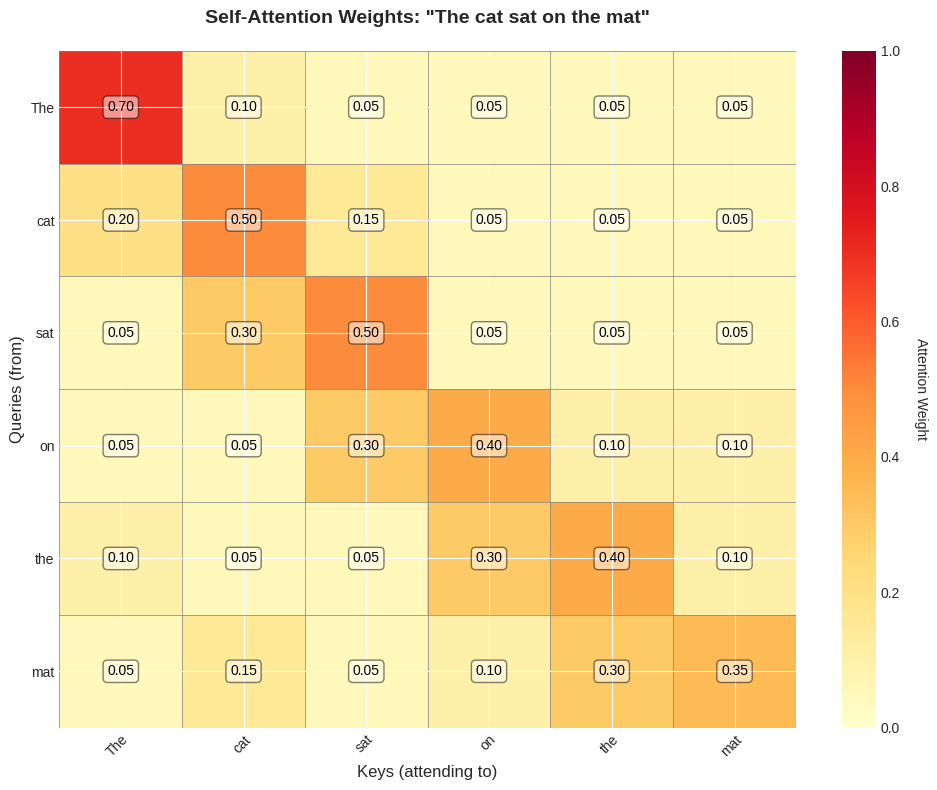


Interpretation:
  - Darker colors indicate stronger attention
  - 'cat' attends to both 'The' and 'cat' (subject)
  - 'sat' attends strongly to 'cat' (who sat?)
  - 'mat' attends to 'the' and 'mat' (object)


In [3]:
# Create a more meaningful example with words
# Let's simulate attention for a sentence: "The cat sat on the mat"

words = ["The", "cat", "sat", "on", "the", "mat"]
seq_len = len(words)

# Create attention pattern that makes semantic sense
# The model should pay attention to related words
attention_example = np.array([
    [0.7, 0.1, 0.05, 0.05, 0.05, 0.05],  # "The" -> "The" (strong)
    [0.2, 0.5, 0.15, 0.05, 0.05, 0.05],  # "cat" -> "The cat"
    [0.05, 0.3, 0.5, 0.05, 0.05, 0.05],  # "sat" -> "cat sat"
    [0.05, 0.05, 0.3, 0.4, 0.1, 0.1],    # "on" -> "sat on"
    [0.1, 0.05, 0.05, 0.3, 0.4, 0.1],    # "the" -> "on the"
    [0.05, 0.15, 0.05, 0.1, 0.3, 0.35],  # "mat" -> "the mat"
])

# Visualize attention matrix
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap
im = ax.imshow(attention_example, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)

# Set ticks and labels
ax.set_xticks(np.arange(len(words)))
ax.set_yticks(np.arange(len(words)))
ax.set_xticklabels(words)
ax.set_yticklabels(words)

# Rotate the tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Attention Weight', rotation=270, labelpad=20)

# Loop over data dimensions and create text annotations
for i in range(len(words)):
    for j in range(len(words)):
        text = ax.text(j, i, f'{attention_example[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=10,
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax.set_title('Self-Attention Weights: "The cat sat on the mat"', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Keys (attending to)', fontsize=12)
ax.set_ylabel('Queries (from)', fontsize=12)

# Add grid
ax.set_xticks(np.arange(len(words))-0.5, minor=True)
ax.set_yticks(np.arange(len(words))-0.5, minor=True)
ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  - Darker colors indicate stronger attention")
print("  - 'cat' attends to both 'The' and 'cat' (subject)")
print("  - 'sat' attends strongly to 'cat' (who sat?)")
print("  - 'mat' attends to 'the' and 'mat' (object)")

## Positional Encoding Implementation

Since transformers process all positions in parallel (unlike RNNs which process sequentially), we need to inject information about the position of each token in the sequence. The original transformer paper uses sinusoidal position encoding.

### Why Sinusoidal Functions?

1. **Uniqueness**: Each position gets a unique encoding
2. **Relative Positions**: The model can learn to attend by relative positions
3. **Extrapolation**: Can handle sequences longer than those seen in training
4. **Smooth Transitions**: Similar positions have similar encodings

Positional Encoding shape: (50, 128)

First position encoding (first 10 dimensions):
[0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]

Second position encoding (first 10 dimensions):
[0.84147098 0.54030231 0.76172041 0.64790587 0.68156135 0.73176098
 0.60469402 0.79645787 0.53316844 0.84600911]


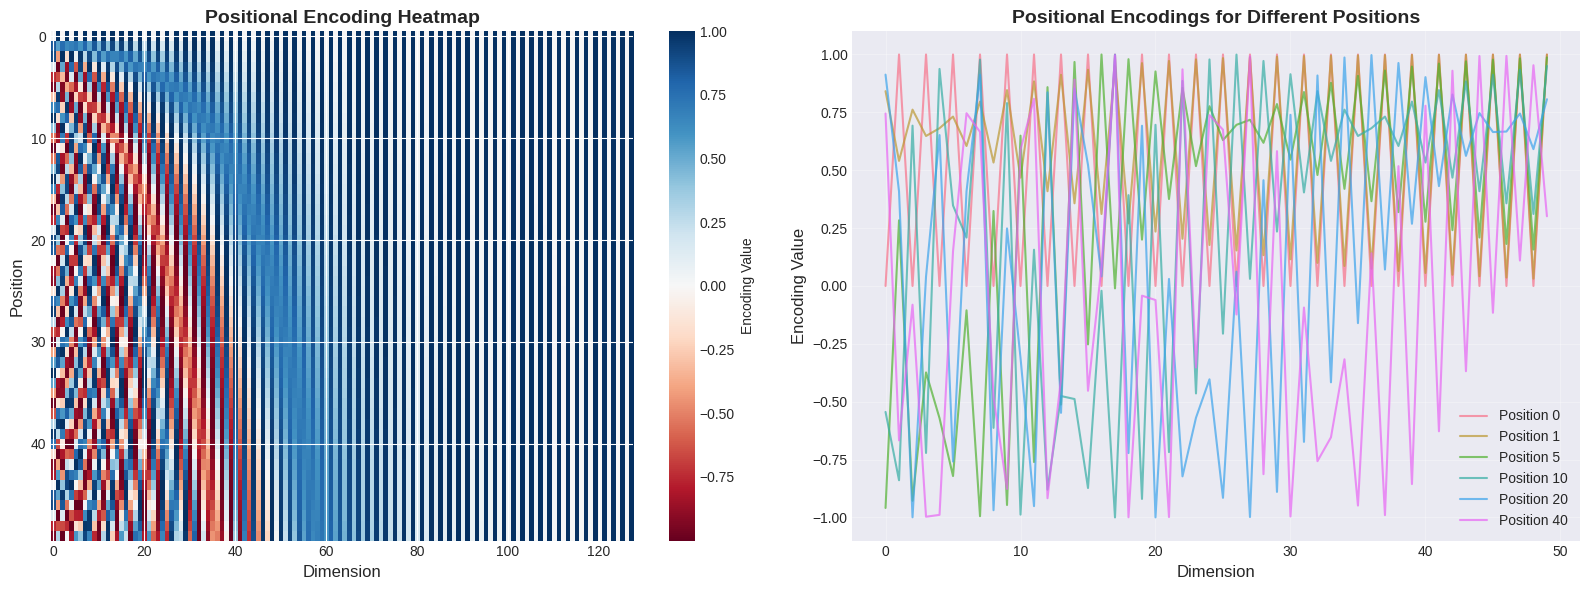


Key Properties:
  - Each position has a unique pattern
  - Values range from [-1.00, 1.00]
  - Lower dimensions have faster oscillations
  - Higher dimensions have slower oscillations


In [4]:
def positional_encoding(seq_len, d_model):
    """
    Generate positional encoding matrix.

    Args:
        seq_len: Length of the sequence
        d_model: Dimension of the model

    Returns:
        pos_encoding: Positional encoding matrix of shape (seq_len, d_model)
    """
    pos_encoding = np.zeros((seq_len, d_model))

    # Create position indices
    position = np.arange(seq_len)[:, np.newaxis]

    # Create dimension indices
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

    # Apply sine to even indices
    pos_encoding[:, 0::2] = np.sin(position * div_term)

    # Apply cosine to odd indices
    pos_encoding[:, 1::2] = np.cos(position * div_term)

    return pos_encoding

# Generate positional encoding
seq_len = 50
d_model = 128

pos_enc = positional_encoding(seq_len, d_model)

print(f"Positional Encoding shape: {pos_enc.shape}")
print(f"\nFirst position encoding (first 10 dimensions):")
print(pos_enc[0, :10])
print(f"\nSecond position encoding (first 10 dimensions):")
print(pos_enc[1, :10])

# Visualize positional encoding
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Heatmap of positional encodings
ax1 = axes[0]
im1 = ax1.imshow(pos_enc, cmap='RdBu', aspect='auto')
ax1.set_xlabel('Dimension', fontsize=12)
ax1.set_ylabel('Position', fontsize=12)
ax1.set_title('Positional Encoding Heatmap', fontsize=14, fontweight='bold')
plt.colorbar(im1, ax=ax1, label='Encoding Value')

# Plot 2: Individual position encodings
ax2 = axes[1]
positions_to_plot = [0, 1, 5, 10, 20, 40]
for pos in positions_to_plot:
    ax2.plot(pos_enc[pos, :50], label=f'Position {pos}', alpha=0.7)
ax2.set_xlabel('Dimension', fontsize=12)
ax2.set_ylabel('Encoding Value', fontsize=12)
ax2.set_title('Positional Encodings for Different Positions', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze properties
print("\nKey Properties:")
print(f"  - Each position has a unique pattern")
print(f"  - Values range from [{pos_enc.min():.2f}, {pos_enc.max():.2f}]")
print(f"  - Lower dimensions have faster oscillations")
print(f"  - Higher dimensions have slower oscillations")

## Multi-Head Attention

Multi-head attention allows the model to jointly attend to information from different representation subspaces. Instead of performing a single attention function, we perform multiple attention operations in parallel.

### Architecture

For $h$ attention heads:

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

where:

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$

### Benefits

1. **Multiple Perspectives**: Each head can focus on different aspects (syntax, semantics, etc.)
2. **Richer Representations**: Captures various relationships simultaneously
3. **Improved Learning**: Different heads specialize in different patterns

### Typical Configuration

- BERT-base: 12 heads, $d_{model} = 768$, $d_k = d_v = 64$ per head
- GPT-3: 96 heads, $d_{model} = 12288$, $d_k = d_v = 128$ per head

In [5]:
class MultiHeadAttention:
    """Multi-head attention mechanism."""

    def __init__(self, d_model, num_heads):
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Initialize weight matrices (in practice, these would be learned)
        self.W_q = np.random.randn(d_model, d_model) * 0.01
        self.W_k = np.random.randn(d_model, d_model) * 0.01
        self.W_v = np.random.randn(d_model, d_model) * 0.01
        self.W_o = np.random.randn(d_model, d_model) * 0.01

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, d_k)."""
        x = x.reshape(batch_size, -1, self.num_heads, self.d_k)
        return x.transpose(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, d_k)

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.shape[0]

        # Linear projections
        Q = np.matmul(Q, self.W_q)
        K = np.matmul(K, self.W_k)
        V = np.matmul(V, self.W_v)

        # Split into multiple heads
        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)

        # Apply attention for each head
        d_k = Q.shape[-1]
        scores = np.matmul(Q, K.transpose(0, 1, 3, 2)) / np.sqrt(d_k)

        if mask is not None:
            scores = scores + (mask * -1e9)

        attention_weights = softmax(scores, axis=-1)
        attention_output = np.matmul(attention_weights, V)

        # Concatenate heads
        attention_output = attention_output.transpose(0, 2, 1, 3).reshape(batch_size, -1, self.d_model)

        # Final linear projection
        output = np.matmul(attention_output, self.W_o)

        return output, attention_weights

# Example usage
print("="*60)
print("MULTI-HEAD ATTENTION EXAMPLE")
print("="*60)

batch_size = 2
seq_len = 10
d_model = 64
num_heads = 8

# Create multi-head attention layer
mha = MultiHeadAttention(d_model, num_heads)

# Create input data
x = np.random.randn(batch_size, seq_len, d_model)

# Forward pass
output, attn_weights = mha.forward(x, x, x)

print(f"\nInput shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")
print(f"\nNumber of heads: {num_heads}")
print(f"Dimension per head (d_k): {mha.d_k}")
print(f"\nFirst 5 output values (first sample, first position):")
print(output[0, 0, :5])

MULTI-HEAD ATTENTION EXAMPLE

Input shape: (2, 10, 64)
Output shape: (2, 10, 64)
Attention weights shape: (2, 8, 10, 10)

Number of heads: 8
Dimension per head (d_k): 8

First 5 output values (first sample, first position):
[-0.00412789  0.00149507  0.00038399 -0.00151757  0.00179879]


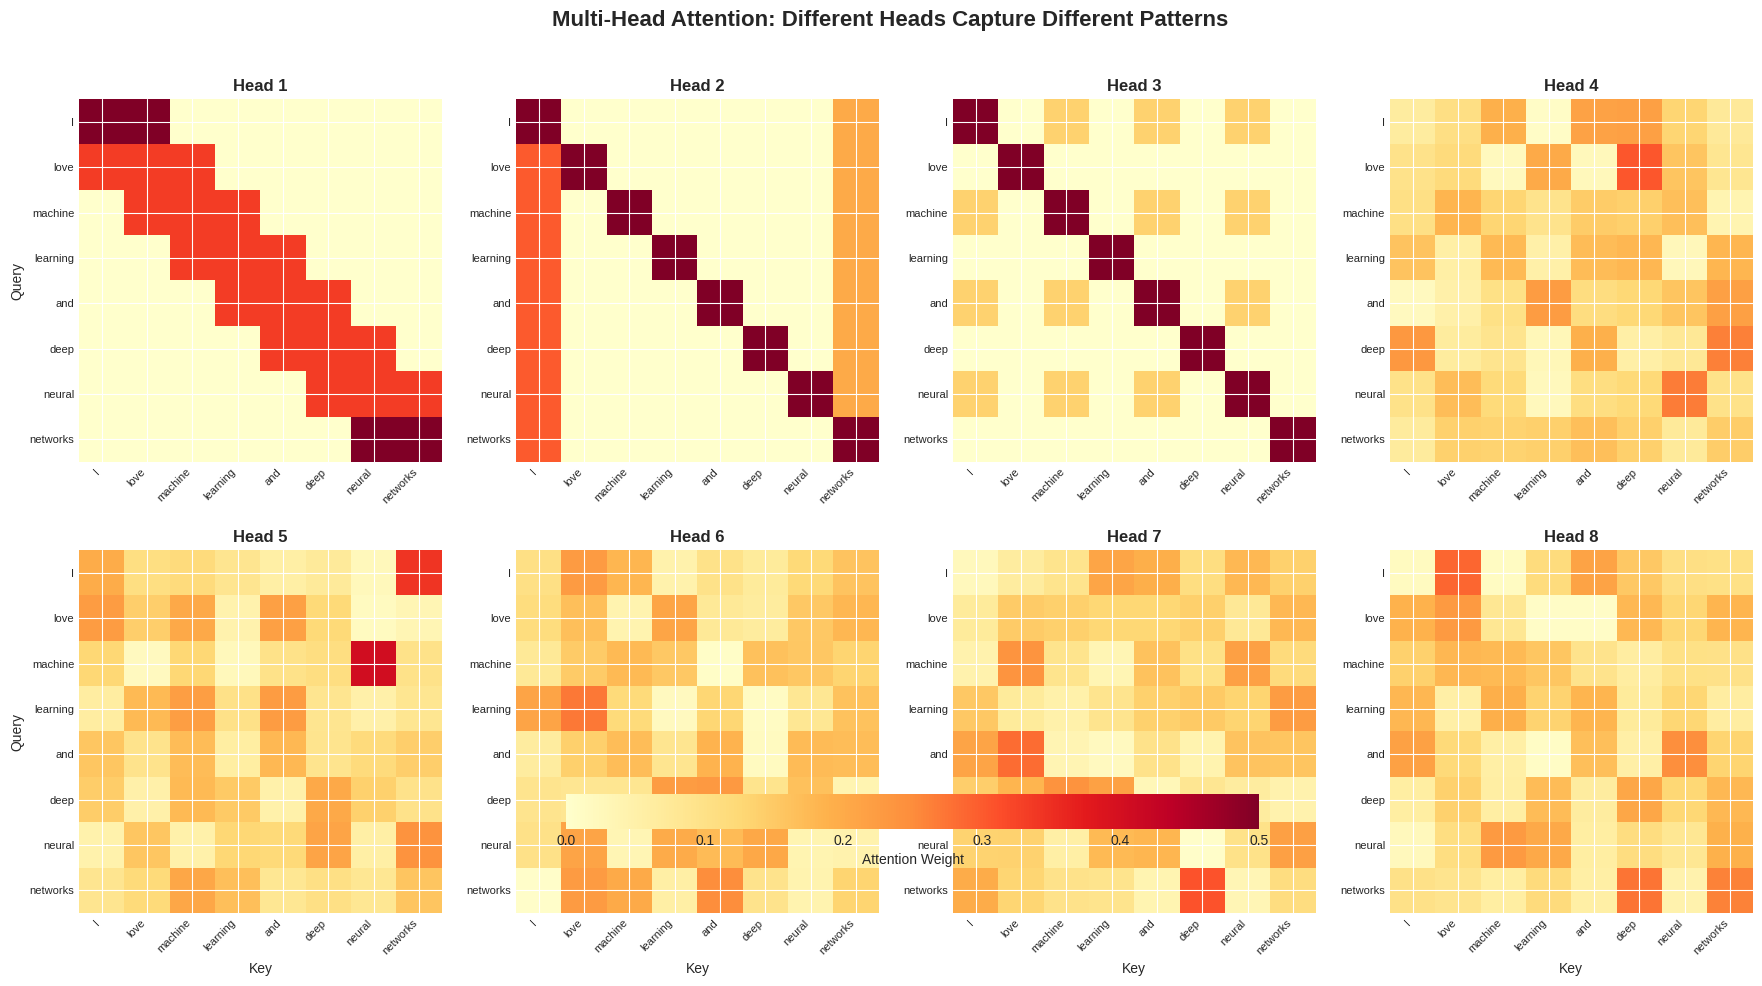


Observations:
  - Each head learns to focus on different aspects of the input
  - Head 1: Focuses on adjacent words (local context)
  - Head 2: Focuses on start/end of sequence (global context)
  - Head 3: Focuses on alternating words (structural patterns)
  - Other heads capture more complex, task-specific patterns


In [6]:
# Visualize attention patterns from different heads
fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

# Create a simple example with meaningful patterns
seq_len_vis = 8
words_vis = ["I", "love", "machine", "learning", "and", "deep", "neural", "networks"]

for head_idx in range(8):
    ax = axes[head_idx]

    # Create different attention patterns for each head
    # Simulate that different heads focus on different relationships
    if head_idx == 0:  # Adjacent words
        attn = np.eye(seq_len_vis) + np.eye(seq_len_vis, k=1) + np.eye(seq_len_vis, k=-1)
    elif head_idx == 1:  # First and last words
        attn = np.eye(seq_len_vis) * 0.5
        attn[:, 0] += 0.3
        attn[:, -1] += 0.2
    elif head_idx == 2:  # Every other word
        attn = np.eye(seq_len_vis)
        for i in range(0, seq_len_vis, 2):
            for j in range(0, seq_len_vis, 2):
                attn[i, j] += 0.3
    else:  # Random patterns for other heads
        attn = np.random.rand(seq_len_vis, seq_len_vis)

    # Normalize to sum to 1 per row
    attn = attn / attn.sum(axis=1, keepdims=True)

    # Plot
    im = ax.imshow(attn, cmap='YlOrRd', vmin=0, vmax=0.5)
    ax.set_title(f'Head {head_idx + 1}', fontweight='bold')
    ax.set_xticks(range(seq_len_vis))
    ax.set_yticks(range(seq_len_vis))
    ax.set_xticklabels(words_vis, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(words_vis, fontsize=8)

    if head_idx % 4 == 0:
        ax.set_ylabel('Query', fontsize=10)
    if head_idx >= 4:
        ax.set_xlabel('Key', fontsize=10)

# Add a shared colorbar
fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1, label='Attention Weight')
fig.suptitle('Multi-Head Attention: Different Heads Capture Different Patterns',
             fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("  - Each head learns to focus on different aspects of the input")
print("  - Head 1: Focuses on adjacent words (local context)")
print("  - Head 2: Focuses on start/end of sequence (global context)")
print("  - Head 3: Focuses on alternating words (structural patterns)")
print("  - Other heads capture more complex, task-specific patterns")

## The Complete Transformer Architecture

### Encoder-Decoder Structure

The original transformer consists of:

1. **Encoder**: Maps input sequence to continuous representations
2. **Decoder**: Generates output sequence from encoder representations

### Encoder Layer

Each encoder layer contains:

1. **Multi-Head Self-Attention**: Allows each position to attend to all positions
2. **Add & Norm**: Residual connection + layer normalization
3. **Feed-Forward Network**: Two linear transformations with ReLU activation
4. **Add & Norm**: Another residual connection + layer normalization

$$\text{LayerNorm}(x + \text{Sublayer}(x))$$

### Feed-Forward Network

$$\text{FFN}(x) = \text{ReLU}(xW_1 + b_1)W_2 + b_2$$

Typically: $d_{model} = 512$, $d_{ff} = 2048$

### Decoder Layer

Similar to encoder but with three sub-layers:

1. **Masked Multi-Head Self-Attention**: Prevents attending to future positions
2. **Add & Norm**
3. **Multi-Head Cross-Attention**: Attends to encoder output
4. **Add & Norm**
5. **Feed-Forward Network**
6. **Add & Norm**

### Complete Model

- Stack of $N$ encoder layers (typically $N=6$)
- Stack of $N$ decoder layers
- Input/output embeddings
- Positional encoding
- Final linear layer + softmax for output probabilities

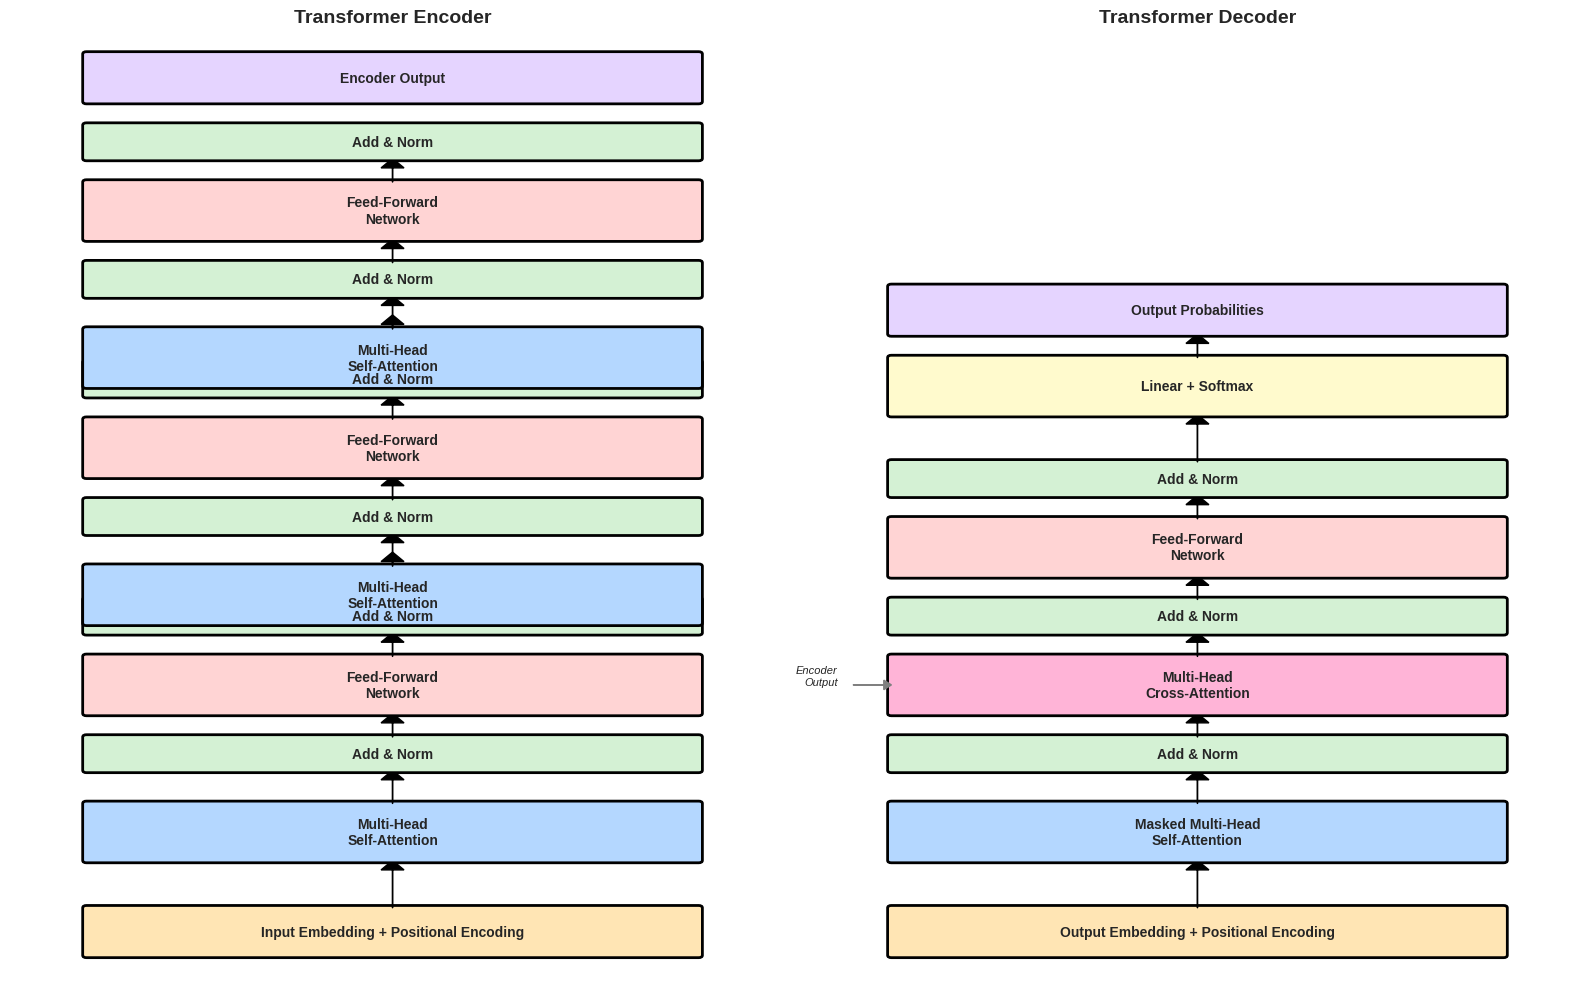

Key Components:

Encoder:
  1. Multi-Head Self-Attention: Relates different positions of input
  2. Feed-Forward Network: Processes each position independently
  3. Residual connections + Layer Normalization: Stabilizes training

Decoder:
  1. Masked Self-Attention: Prevents looking at future tokens
  2. Cross-Attention: Incorporates encoder information
  3. Feed-Forward Network: Same as encoder
  4. Linear + Softmax: Produces output probabilities


In [7]:
# Create a diagram of the transformer architecture
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

# Helper function to draw a box
def draw_box(ax, x, y, width, height, text, color='lightblue'):
    box = FancyBboxPatch((x, y), width, height, boxstyle="round,pad=0.05",
                         edgecolor='black', facecolor=color, linewidth=2)
    ax.add_patch(box)
    ax.text(x + width/2, y + height/2, text, ha='center', va='center',
            fontsize=10, fontweight='bold', wrap=True)

# Encoder visualization
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 20)
ax1.axis('off')
ax1.set_title('Transformer Encoder', fontsize=14, fontweight='bold')

# Input
draw_box(ax1, 1, 0.5, 8, 1, 'Input Embedding + Positional Encoding', '#FFE5B4')
ax1.arrow(5, 1.5, 0, 0.8, head_width=0.3, head_length=0.2, fc='black', ec='black')

# Encoder layers (3 shown, representing N layers)
for i, layer_num in enumerate([1, 2, 3]):
    y_base = 2.5 + i * 5

    # Multi-head attention
    draw_box(ax1, 1, y_base, 8, 1.2, 'Multi-Head\nSelf-Attention', '#B4D7FF')
    ax1.arrow(5, y_base + 1.2, 0, 0.5, head_width=0.3, head_length=0.2, fc='black', ec='black')

    # Add & Norm
    draw_box(ax1, 1, y_base + 1.9, 8, 0.7, 'Add & Norm', '#D4F1D4')
    ax1.arrow(5, y_base + 2.6, 0, 0.3, head_width=0.3, head_length=0.2, fc='black', ec='black')

    # Feed Forward
    draw_box(ax1, 1, y_base + 3.1, 8, 1.2, 'Feed-Forward\nNetwork', '#FFD4D4')
    ax1.arrow(5, y_base + 4.3, 0, 0.3, head_width=0.3, head_length=0.2, fc='black', ec='black')

    # Add & Norm
    draw_box(ax1, 1, y_base + 4.8, 8, 0.7, 'Add & Norm', '#D4F1D4')

    if i < 2:
        ax1.arrow(5, y_base + 5.5, 0, 0.8, head_width=0.3, head_length=0.2, fc='black', ec='black')

# Output
draw_box(ax1, 1, 18.5, 8, 1, 'Encoder Output', '#E5D4FF')

# Decoder visualization
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 20)
ax2.axis('off')
ax2.set_title('Transformer Decoder', fontsize=14, fontweight='bold')

# Output (shifted right)
draw_box(ax2, 1, 0.5, 8, 1, 'Output Embedding + Positional Encoding', '#FFE5B4')
ax2.arrow(5, 1.5, 0, 0.8, head_width=0.3, head_length=0.2, fc='black', ec='black')

# Decoder layer
y_base = 2.5

# Masked Multi-head attention
draw_box(ax2, 1, y_base, 8, 1.2, 'Masked Multi-Head\nSelf-Attention', '#B4D7FF')
ax2.arrow(5, y_base + 1.2, 0, 0.5, head_width=0.3, head_length=0.2, fc='black', ec='black')

# Add & Norm
draw_box(ax2, 1, y_base + 1.9, 8, 0.7, 'Add & Norm', '#D4F1D4')
ax2.arrow(5, y_base + 2.6, 0, 0.3, head_width=0.3, head_length=0.2, fc='black', ec='black')

# Cross-attention
draw_box(ax2, 1, y_base + 3.1, 8, 1.2, 'Multi-Head\nCross-Attention', '#FFB4D7')
ax2.text(0.3, y_base + 3.7, 'Encoder\nOutput', fontsize=8, ha='right', style='italic')
ax2.arrow(0.5, y_base + 3.7, 0.4, 0, head_width=0.2, head_length=0.1, fc='gray', ec='gray')
ax2.arrow(5, y_base + 4.3, 0, 0.3, head_width=0.3, head_length=0.2, fc='black', ec='black')

# Add & Norm
draw_box(ax2, 1, y_base + 4.8, 8, 0.7, 'Add & Norm', '#D4F1D4')
ax2.arrow(5, y_base + 5.5, 0, 0.3, head_width=0.3, head_length=0.2, fc='black', ec='black')

# Feed Forward
draw_box(ax2, 1, y_base + 6, 8, 1.2, 'Feed-Forward\nNetwork', '#FFD4D4')
ax2.arrow(5, y_base + 7.2, 0, 0.3, head_width=0.3, head_length=0.2, fc='black', ec='black')

# Add & Norm
draw_box(ax2, 1, y_base + 7.7, 8, 0.7, 'Add & Norm', '#D4F1D4')
ax2.arrow(5, y_base + 8.4, 0, 0.8, head_width=0.3, head_length=0.2, fc='black', ec='black')

# Linear + Softmax
draw_box(ax2, 1, y_base + 9.4, 8, 1.2, 'Linear + Softmax', '#FFFACD')
ax2.arrow(5, y_base + 10.6, 0, 0.3, head_width=0.3, head_length=0.2, fc='black', ec='black')

# Output probabilities
draw_box(ax2, 1, y_base + 11.1, 8, 1, 'Output Probabilities', '#E5D4FF')

plt.tight_layout()
plt.show()

print("Key Components:")
print("\nEncoder:")
print("  1. Multi-Head Self-Attention: Relates different positions of input")
print("  2. Feed-Forward Network: Processes each position independently")
print("  3. Residual connections + Layer Normalization: Stabilizes training")
print("\nDecoder:")
print("  1. Masked Self-Attention: Prevents looking at future tokens")
print("  2. Cross-Attention: Incorporates encoder information")
print("  3. Feed-Forward Network: Same as encoder")
print("  4. Linear + Softmax: Produces output probabilities")

## Attention Masking

### Why Masking?

In sequence generation tasks, we need to prevent the model from "cheating" by looking at future tokens. This is accomplished through **masking**.

### Types of Masks

1. **Padding Mask**: Ignore padding tokens
   - Used in both encoder and decoder
   - Prevents attention to padding positions

2. **Look-Ahead Mask** (Causal Mask): Prevent attending to future positions
   - Used only in decoder self-attention
   - Ensures autoregressive property
   - Upper triangular matrix of -∞ or very large negative numbers

### Mathematical Formulation

For position $i$, can only attend to positions $j \leq i$:

$$\text{Mask}[i,j] = \begin{cases}
0 & \text{if } j \leq i \\
-\infty & \text{if } j > i
\end{cases}$$

After applying mask to attention scores:

$$\text{scores\_masked} = \text{scores} + \text{mask}$$

The softmax will then assign near-zero probability to masked positions.

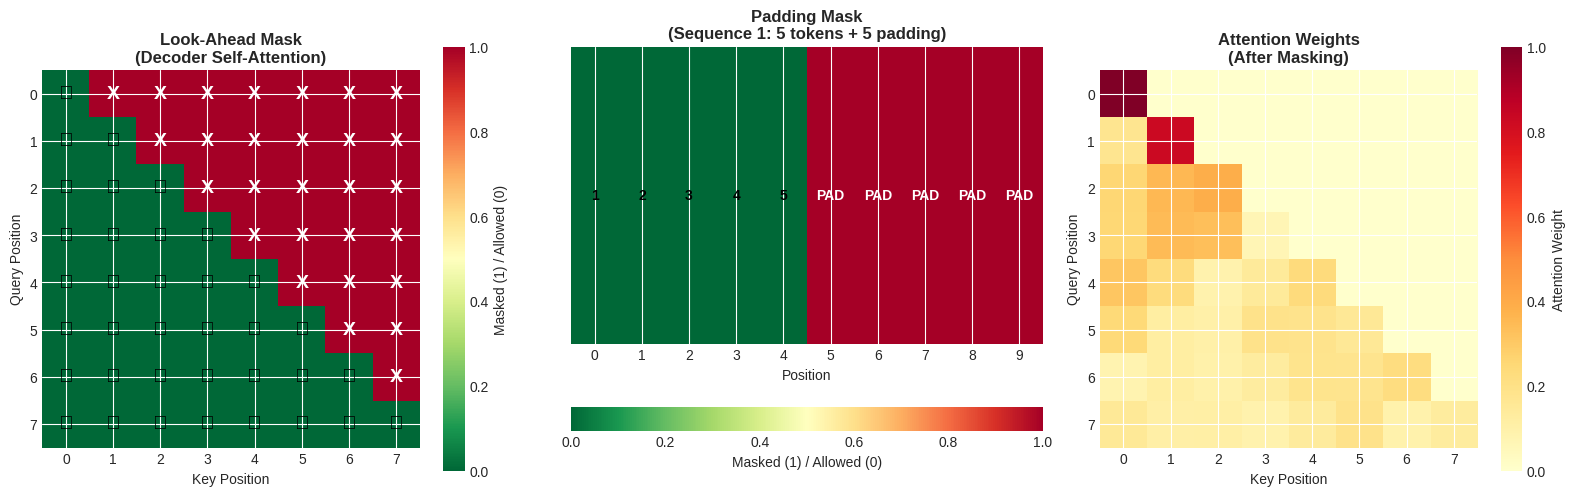

Masking Explanation:

1. Look-Ahead Mask (Left):
   - X = Masked (cannot attend)
   - ✓ = Allowed (can attend)
   - Each position can only attend to current and previous positions
   - Ensures autoregressive generation

2. Padding Mask (Middle):
   - Masks padding tokens (shown as 'PAD')
   - Prevents model from attending to meaningless padding
   - Important for variable-length sequences

3. Effect After Masking (Right):
   - Masked positions get near-zero attention weight
   - Only valid positions receive attention
   - Each row sums to 1.0


In [8]:
def create_look_ahead_mask(size):
    """
    Create a mask to prevent attending to future positions.
    Returns a matrix where upper triangle is -inf.
    """
    mask = np.triu(np.ones((size, size)), k=1)
    return mask * -1e9

def create_padding_mask(seq, pad_token=0):
    """
    Create a mask to ignore padding tokens.
    """
    # Create mask where padding tokens are 1, others are 0
    mask = (seq == pad_token).astype(float)
    # Expand dimensions for broadcasting: (batch_size, 1, 1, seq_len)
    return mask[:, np.newaxis, np.newaxis, :]

# Example: Look-ahead mask
size = 8
look_ahead_mask = create_look_ahead_mask(size)

# Convert to binary for visualization (1 = masked, 0 = not masked)
look_ahead_binary = (look_ahead_mask < -1).astype(int)

# Example: Padding mask
batch_size = 3
seq_len = 10
# Create sequences with padding (0 = padding token)
sequences = np.array([
    [1, 2, 3, 4, 5, 0, 0, 0, 0, 0],  # sequence 1: 5 tokens, 5 padding
    [1, 2, 3, 4, 5, 6, 7, 0, 0, 0],  # sequence 2: 7 tokens, 3 padding
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], # sequence 3: 10 tokens, 0 padding
])

padding_mask = create_padding_mask(sequences)

# Visualize masks
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Look-ahead mask
ax1 = axes[0]
im1 = ax1.imshow(look_ahead_binary, cmap='RdYlGn_r', vmin=0, vmax=1)
ax1.set_title('Look-Ahead Mask\n(Decoder Self-Attention)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Key Position', fontsize=10)
ax1.set_ylabel('Query Position', fontsize=10)
ax1.set_xticks(range(size))
ax1.set_yticks(range(size))

# Add annotations
for i in range(size):
    for j in range(size):
        text = 'X' if look_ahead_binary[i, j] else '✓'
        color = 'white' if look_ahead_binary[i, j] else 'black'
        ax1.text(j, i, text, ha='center', va='center', color=color, fontsize=14, fontweight='bold')

plt.colorbar(im1, ax=ax1, label='Masked (1) / Allowed (0)')

# Plot 2: Padding mask for sequence 1
ax2 = axes[1]
pad_mask_seq1 = padding_mask[0, 0, 0, :].reshape(1, -1)
im2 = ax2.imshow(pad_mask_seq1, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=1)
ax2.set_title('Padding Mask\n(Sequence 1: 5 tokens + 5 padding)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Position', fontsize=10)
ax2.set_yticks([])
ax2.set_xticks(range(seq_len))

# Add annotations
for j in range(seq_len):
    text = 'PAD' if pad_mask_seq1[0, j] > 0 else str(sequences[0, j])
    color = 'white' if pad_mask_seq1[0, j] > 0 else 'black'
    ax2.text(j, 0, text, ha='center', va='center', color=color, fontsize=10, fontweight='bold')

plt.colorbar(im2, ax=ax2, label='Masked (1) / Allowed (0)', orientation='horizontal')

# Plot 3: Combined mask effect
ax3 = axes[2]
# Simulate attention scores before masking
attention_scores = np.random.randn(size, size) * 0.5
# Apply look-ahead mask
attention_scores_masked = attention_scores + look_ahead_mask
# Apply softmax
attention_weights_masked = softmax(attention_scores_masked, axis=-1)

im3 = ax3.imshow(attention_weights_masked, cmap='YlOrRd', vmin=0, vmax=np.max(attention_weights_masked))
ax3.set_title('Attention Weights\n(After Masking)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Key Position', fontsize=10)
ax3.set_ylabel('Query Position', fontsize=10)
ax3.set_xticks(range(size))
ax3.set_yticks(range(size))

plt.colorbar(im3, ax=ax3, label='Attention Weight')

plt.tight_layout()
plt.show()

print("Masking Explanation:")
print("\n1. Look-Ahead Mask (Left):")
print("   - X = Masked (cannot attend)")
print("   - ✓ = Allowed (can attend)")
print("   - Each position can only attend to current and previous positions")
print("   - Ensures autoregressive generation")
print("\n2. Padding Mask (Middle):")
print("   - Masks padding tokens (shown as 'PAD')")
print("   - Prevents model from attending to meaningless padding")
print("   - Important for variable-length sequences")
print("\n3. Effect After Masking (Right):")
print("   - Masked positions get near-zero attention weight")
print("   - Only valid positions receive attention")
print("   - Each row sums to 1.0")

## Real-World Applications of Transformers

Transformers have revolutionized numerous fields beyond NLP:

### Natural Language Processing

1. **Machine Translation**
   - Google Translate, DeepL
   - Significantly improved translation quality
   - Handles context better than RNN-based systems

2. **Text Generation**
   - GPT-3, GPT-4: Advanced language models
   - ChatGPT: Conversational AI
   - GitHub Copilot: Code generation
   - Claude: Advanced AI assistant (built on transformer architecture)

3. **Question Answering**
   - Reading comprehension systems
   - Customer support automation
   - Information retrieval

4. **Text Classification**
   - Sentiment analysis
   - Spam detection
   - Content moderation

### Computer Vision

1. **Vision Transformers (ViT)**
   - Image classification without convolutions
   - Competitive with CNNs on many tasks

2. **Image Generation**
   - DALL-E: Text-to-image generation
   - Stable Diffusion: High-quality image synthesis

3. **Object Detection**
   - DETR (Detection Transformer)
   - End-to-end object detection

### Multimodal Applications

1. **CLIP**: Connecting vision and language
2. **Flamingo**: Visual question answering
3. **GPT-4**: Multimodal understanding (text + images)

### Scientific Applications

1. **Protein Structure Prediction**: AlphaFold 2
2. **Drug Discovery**: Molecule generation and property prediction
3. **Time Series Forecasting**: Weather, stock prices, energy demand

### Key Transformer Models

| Model | Year | Type | Parameters | Key Innovation |
|-------|------|------|------------|----------------|
| Transformer | 2017 | Encoder-Decoder | - | Original architecture |
| BERT | 2018 | Encoder | 110M-340M | Bidirectional pre-training |
| GPT-2 | 2019 | Decoder | 1.5B | Large-scale language modeling |
| T5 | 2019 | Encoder-Decoder | 11B | Text-to-text framework |
| GPT-3 | 2020 | Decoder | 175B | Few-shot learning |
| ViT | 2020 | Encoder | 86M-632M | Image patches as tokens |
| CLIP | 2021 | Dual Encoder | 400M | Vision-language connection |
| GPT-4 | 2023 | Decoder | Unknown | Multimodal capabilities |

## Computational Complexity and Challenges

### Complexity Analysis

For a sequence of length $n$ and model dimension $d_{model}$:

1. **Self-Attention Complexity**: $O(n^2 \cdot d_{model})$
   - Computing $QK^T$: $O(n^2 \cdot d_k)$
   - Multiplying by $V$: $O(n^2 \cdot d_v)$
   - **Bottleneck for long sequences**

2. **Feed-Forward Network**: $O(n \cdot d_{model}^2)$
   - Two linear transformations per position
   - Parallelizable across positions

3. **Total per Layer**: $O(n^2 \cdot d_{model} + n \cdot d_{model}^2)$

### Memory Requirements

- **Attention Matrix**: Stores $n \times n$ attention weights per head
- For $h$ heads: $O(h \cdot n^2)$ memory
- Becomes prohibitive for long sequences (e.g., $n > 10000$)

### Challenges and Solutions

| Challenge | Problem | Solutions |
|-----------|---------|-----------|
| **Quadratic Complexity** | $O(n^2)$ grows quickly | Sparse attention, Linear attention |
| **Memory Limits** | Can't fit long sequences | Gradient checkpointing, Model parallelism |
| **Training Time** | Billions of parameters | Distributed training, Mixed precision |
| **Long-Range Dependencies** | Fixed context window | Recurrent memory, Hierarchical attention |

### Efficient Transformer Variants

1. **Sparse Transformers**: Only attend to subset of positions
2. **Linformer**: Projects keys and values to lower dimension
3. **Reformer**: Uses locality-sensitive hashing
4. **Longformer**: Combines local and global attention
5. **BigBird**: Sparse attention patterns for long documents
6. **Flash Attention**: Optimized attention computation

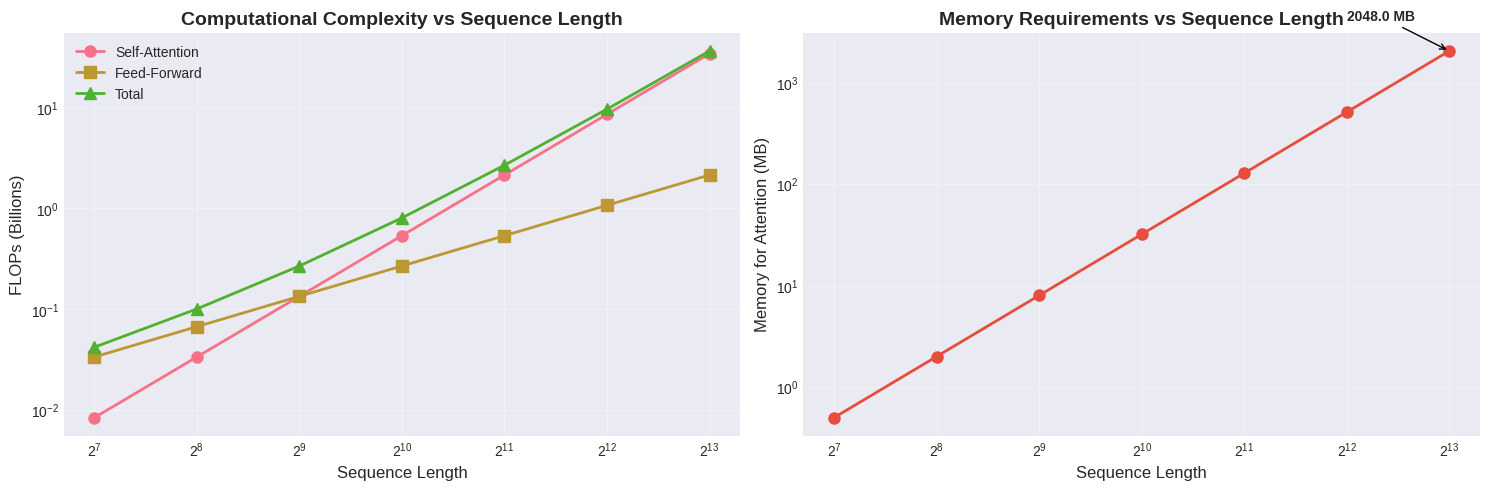

Complexity Analysis:
Seq Length   Attention (GFLOPs)   FF (GFLOPs)     Memory (MB)    
128          0.01                 0.03            0.5            
256          0.03                 0.07            2.0            
512          0.13                 0.13            8.0            
1024         0.54                 0.27            32.0           
2048         2.15                 0.54            128.0          
4096         8.59                 1.07            512.0          
8192         34.36                2.15            2048.0         

Key Observations:
  - Attention complexity grows quadratically with sequence length
  - For n=8192: 2048.0 MB just for attention matrix
  - Feed-forward complexity is linear in sequence length
  - Self-attention becomes the bottleneck for long sequences


In [9]:
# Visualize computational complexity
sequence_lengths = np.array([128, 256, 512, 1024, 2048, 4096, 8192])
d_model = 512

# Attention complexity: O(n^2 * d)
attention_ops = sequence_lengths**2 * d_model

# Feed-forward complexity: O(n * d^2)
ff_ops = sequence_lengths * d_model**2

# Total complexity
total_ops = attention_ops + ff_ops

# Memory for attention (storing attention matrix)
num_heads = 8
attention_memory = num_heads * sequence_lengths**2 * 4 / (1024**2)  # MB (assuming float32)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Computational complexity
ax1.plot(sequence_lengths, attention_ops / 1e9, 'o-', label='Self-Attention', linewidth=2, markersize=8)
ax1.plot(sequence_lengths, ff_ops / 1e9, 's-', label='Feed-Forward', linewidth=2, markersize=8)
ax1.plot(sequence_lengths, total_ops / 1e9, '^-', label='Total', linewidth=2, markersize=8)
ax1.set_xlabel('Sequence Length', fontsize=12)
ax1.set_ylabel('FLOPs (Billions)', fontsize=12)
ax1.set_title('Computational Complexity vs Sequence Length', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log', base=2)
ax1.set_yscale('log')

# Plot 2: Memory requirements
ax2.plot(sequence_lengths, attention_memory, 'o-', color='#E74C3C', linewidth=2, markersize=8)
ax2.set_xlabel('Sequence Length', fontsize=12)
ax2.set_ylabel('Memory for Attention (MB)', fontsize=12)
ax2.set_title('Memory Requirements vs Sequence Length', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log', base=2)
ax2.set_yscale('log')

# Add annotations for the longest sequence
ax2.annotate(f'{attention_memory[-1]:.1f} MB',
            xy=(sequence_lengths[-1], attention_memory[-1]),
            xytext=(sequence_lengths[-2], attention_memory[-1] * 2),
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("Complexity Analysis:")
print("="*60)
print(f"{'Seq Length':<12} {'Attention (GFLOPs)':<20} {'FF (GFLOPs)':<15} {'Memory (MB)':<15}")
print("="*60)
for n, attn, ff, mem in zip(sequence_lengths, attention_ops/1e9, ff_ops/1e9, attention_memory):
    print(f"{n:<12} {attn:<20.2f} {ff:<15.2f} {mem:<15.1f}")

print("\nKey Observations:")
print(f"  - Attention complexity grows quadratically with sequence length")
print(f"  - For n=8192: {attention_memory[-1]:.1f} MB just for attention matrix")
print(f"  - Feed-forward complexity is linear in sequence length")
print(f"  - Self-attention becomes the bottleneck for long sequences")

## Hands-On Exercise: Build Your Own Attention Mechanism

Now it's your turn to implement and experiment with attention mechanisms!

### Exercise Tasks

1. **Modify the Attention Function**
   - Implement different attention variants (additive attention, multiplicative attention)
   - Experiment with different scaling factors
   - Compare their behaviors

2. **Create Custom Positional Encodings**
   - Implement learned positional embeddings
   - Compare with sinusoidal encodings
   - Visualize the differences

3. **Attention Visualization**
   - Create attention heatmaps for your own sentences
   - Analyze which words attend to which
   - Identify interesting patterns

4. **Multi-Head Analysis**
   - Experiment with different numbers of heads
   - Analyze how each head specializes
   - Plot head diversity metrics

### Starter Code Below

Modify the code below to complete the exercises. Try different hyperparameters and observe the results!

Effect of Different Scaling Factors:

Scale = 1.00:
  Attention weight range: [0.0000, 1.0000]
  Attention weight std: 0.3734

Scale = 8.00:
  Attention weight range: [0.0191, 0.6121]
  Attention weight std: 0.1465

Scale = 64.00:
  Attention weight range: [0.1604, 0.2409]
  Attention weight std: 0.0208

Scale = 100.00:
  Attention weight range: [0.1741, 0.2256]
  Attention weight std: 0.0133


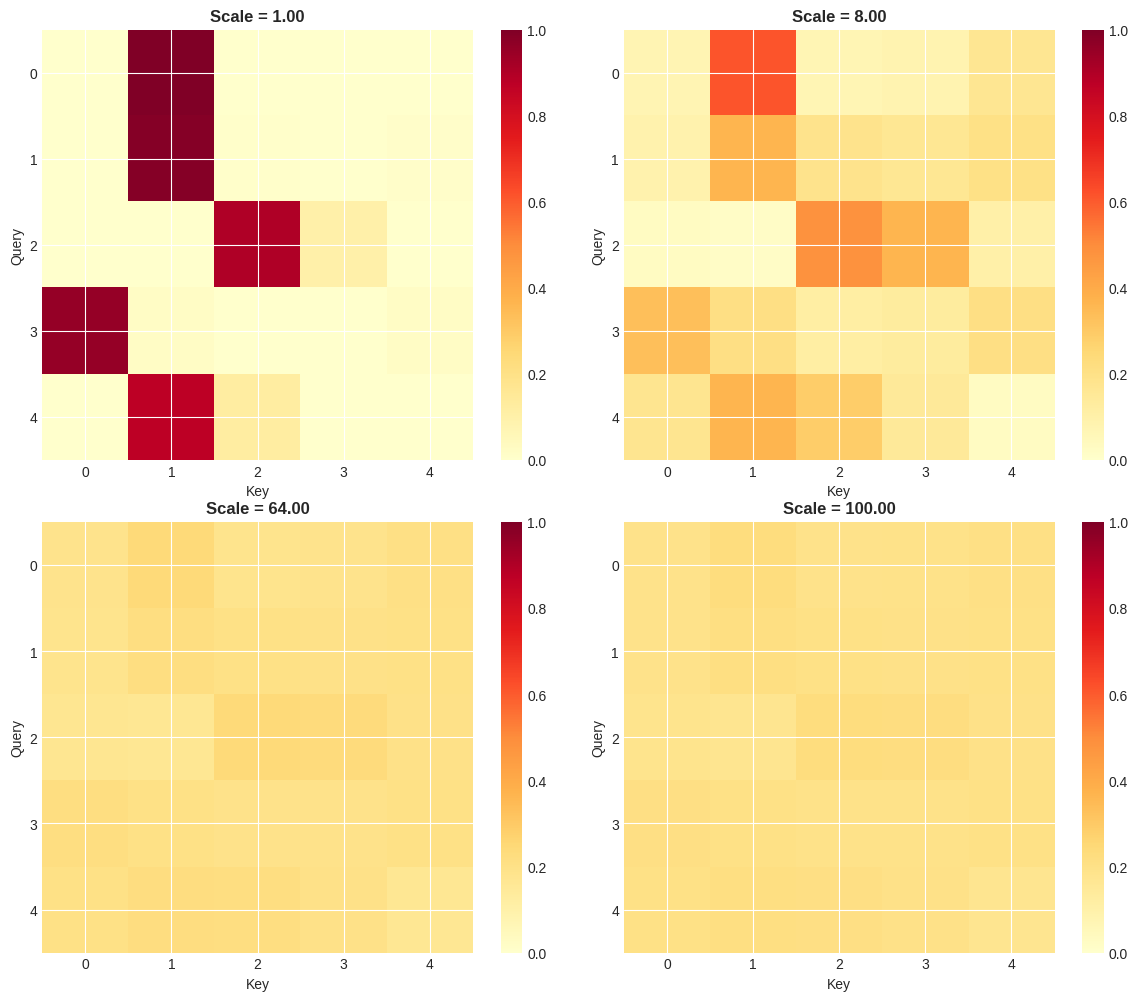


TODO: Try the following experiments:
  1. Implement additive attention: score = v^T * tanh(W1*Q + W2*K)
  2. Create learned positional embeddings and compare with sinusoidal
  3. Visualize attention for a custom sentence of your choice
  4. Implement and visualize cross-attention between two different sequences


In [10]:
# Exercise: Experiment with attention mechanisms

# TODO 1: Try different attention scaling factors
def attention_with_custom_scale(Q, K, V, scale_factor=None):
    """Attention with custom scaling."""
    d_k = Q.shape[-1]

    # Default: sqrt(d_k) scaling
    if scale_factor is None:
        scale = np.sqrt(d_k)
    else:
        scale = scale_factor

    scores = np.matmul(Q, K.transpose(0, 2, 1)) / scale
    attention_weights = softmax(scores, axis=-1)
    output = np.matmul(attention_weights, V)

    return output, attention_weights

# Test with different scaling factors
scales = [1, np.sqrt(64), 64, 100]
batch_size, seq_len, d_k = 1, 5, 64

Q = np.random.randn(batch_size, seq_len, d_k)
K = np.random.randn(batch_size, seq_len, d_k)
V = np.random.randn(batch_size, seq_len, d_k)

print("Effect of Different Scaling Factors:")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, scale in enumerate(scales):
    output, attn_weights = attention_with_custom_scale(Q, K, V, scale)

    ax = axes[idx]
    im = ax.imshow(attn_weights[0], cmap='YlOrRd', vmin=0, vmax=1)
    ax.set_title(f'Scale = {scale:.2f}', fontweight='bold')
    ax.set_xlabel('Key')
    ax.set_ylabel('Query')
    plt.colorbar(im, ax=ax)

    # Print statistics
    print(f"\nScale = {scale:.2f}:")
    print(f"  Attention weight range: [{attn_weights.min():.4f}, {attn_weights.max():.4f}]")
    print(f"  Attention weight std: {attn_weights.std():.4f}")

plt.tight_layout()
plt.show()

print("\nTODO: Try the following experiments:")
print("  1. Implement additive attention: score = v^T * tanh(W1*Q + W2*K)")
print("  2. Create learned positional embeddings and compare with sinusoidal")
print("  3. Visualize attention for a custom sentence of your choice")
print("  4. Implement and visualize cross-attention between two different sequences")

## Key Takeaways

Congratulations! You've learned about transformers and attention mechanisms, one of the most important breakthroughs in modern AI.

### Main Concepts

1. **Attention Mechanism**
   - Allows models to focus on relevant parts of the input
   - Computed using Query, Key, and Value matrices
   - Scaled by $\sqrt{d_k}$ to prevent softmax saturation
   - Formula: $\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$

2. **Self-Attention**
   - Each position attends to all positions in the sequence
   - Captures dependencies regardless of distance
   - Parallelizable (unlike RNNs)

3. **Multi-Head Attention**
   - Multiple attention operations in parallel
   - Each head can focus on different aspects
   - Concatenated and projected to final output

4. **Positional Encoding**
   - Injects sequence order information
   - Sinusoidal functions provide unique, meaningful encodings
   - Enables transformers to understand position

5. **Masking**
   - Look-ahead mask prevents seeing future tokens
   - Padding mask ignores meaningless padding tokens
   - Essential for autoregressive generation

6. **Transformer Architecture**
   - Encoder: Processes input into representations
   - Decoder: Generates output from representations
   - Residual connections + layer normalization for stability
   - Feed-forward networks for additional processing

### Why Transformers Succeeded

✅ **Parallelization**: Unlike RNNs, can process entire sequences at once
✅ **Long-Range Dependencies**: Attention connects any two positions directly
✅ **Scalability**: Architecture scales well with data and compute
✅ **Transfer Learning**: Pre-trained models work across many tasks
✅ **Flexibility**: Applicable to NLP, vision, multimodal tasks, and more

### Computational Considerations

⚠️ **Quadratic Complexity**: $O(n^2)$ attention is expensive for long sequences
⚠️ **Memory Requirements**: Attention matrix can be very large
⚠️ **Parameter Count**: Large models (GPT-3: 175B parameters) need significant resources

### From Theory to Practice

This lesson covered the theoretical foundations and mathematical principles. In the next lessons, we'll:

- **Lesson 84**: Implement transformers using modern libraries (Hugging Face, PyTorch)
- **Lesson 85**: Fine-tune pre-trained transformers for specific tasks
- Explore state-of-the-art models like BERT, GPT, T5
- Learn about efficient training and deployment strategies

### What You Can Now Do

✓ Understand how attention mechanisms work mathematically
✓ Explain the transformer architecture and its components
✓ Implement basic attention from scratch using NumPy
✓ Visualize and interpret attention patterns
✓ Recognize when to use transformers vs other architectures
✓ Understand the computational tradeoffs of transformers

### Next Steps

1. Review the mathematical formulas and ensure you understand each component
2. Complete the hands-on exercises to solidify your understanding
3. Read the original "Attention Is All You Need" paper
4. Experiment with the code: modify hyperparameters, try different visualizations
5. Prepare for Lesson 84 where we'll use real transformer libraries!

## Further Resources

### Essential Papers

1. **Attention Is All You Need** (Vaswani et al., 2017)
   - The original transformer paper
   - [https://arxiv.org/abs/1706.03762](https://arxiv.org/abs/1706.03762)

2. **BERT: Pre-training of Deep Bidirectional Transformers** (Devlin et al., 2018)
   - Bidirectional encoder representations
   - [https://arxiv.org/abs/1810.04805](https://arxiv.org/abs/1810.04805)

3. **Language Models are Few-Shot Learners** (Brown et al., 2020)
   - GPT-3 and in-context learning
   - [https://arxiv.org/abs/2005.14165](https://arxiv.org/abs/2005.14165)

4. **An Image is Worth 16x16 Words** (Dosovitskiy et al., 2020)
   - Vision Transformers (ViT)
   - [https://arxiv.org/abs/2010.11929](https://arxiv.org/abs/2010.11929)

### Tutorials and Visualizations

5. **The Illustrated Transformer** by Jay Alammar
   - Excellent visual explanations
   - [http://jalammar.github.io/illustrated-transformer/](http://jalammar.github.io/illustrated-transformer/)

6. **The Annotated Transformer** by Harvard NLP
   - Line-by-line implementation
   - [http://nlp.seas.harvard.edu/2018/04/03/attention.html](http://nlp.seas.harvard.edu/2018/04/03/attention.html)

7. **Attention? Attention!** by Lilian Weng
   - Comprehensive attention survey
   - [https://lilianweng.github.io/posts/2018-06-24-attention/](https://lilianweng.github.io/posts/2018-06-24-attention/)

### Books

8. **Speech and Language Processing** by Jurafsky & Martin (Chapter 10)
   - Transformers and pre-training in NLP
   - [https://web.stanford.edu/~jurafsky/slp3/](https://web.stanford.edu/~jurafsky/slp3/)

9. **Dive into Deep Learning** (Chapter on Attention)
   - Interactive deep learning book
   - [https://d2l.ai/](https://d2l.ai/)

### Implementations and Libraries

10. **Hugging Face Transformers**
    - State-of-the-art pre-trained models
    - [https://huggingface.co/transformers/](https://huggingface.co/transformers/)

11. **PyTorch Transformer Tutorial**
    - Official PyTorch implementation
    - [https://pytorch.org/tutorials/beginner/transformer_tutorial.html](https://pytorch.org/tutorials/beginner/transformer_tutorial.html)

### Video Lectures

12. **Stanford CS224N: NLP with Deep Learning**
    - Lecture 9: Transformers
    - [https://www.youtube.com/watch?v=ptuGllU5SQQ](https://www.youtube.com/watch?v=ptuGllU5SQQ)

13. **Andrej Karpathy: Let's build GPT**
    - Build transformer from scratch
    - [https://www.youtube.com/watch?v=kCc8FmEb1nY](https://www.youtube.com/watch?v=kCc8FmEb1nY)

### Interactive Resources

14. **Transformer Explainer**
    - Interactive visualization tool
    - [https://poloclub.github.io/transformer-explainer/](https://poloclub.github.io/transformer-explainer/)

15. **BertViz**
    - Visualize BERT attention
    - [https://github.com/jessevig/bertviz](https://github.com/jessevig/bertviz)

Happy learning! 🚀